# Chapter 5 NLP

In [7]:
%matplotlib inline

In [8]:
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import scattertext

import tensorflow as tf
from tensorflow import keras

from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.layers import SimpleRNN, GRU, LSTM, Bidirectional
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint

import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer, SnowballStemmer
from spacy.lang.en import English

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

sns.set()

In [2]:
# import codecs
# import os
# import collections
# from six.moves import cPickle
# import numpy as np


# class TextLoader():
#     def __init__(self, data_dir, batch_size, seq_length, encoding='utf-8'):
#         self.data_dir = data_dir
#         self.batch_size = batch_size
#         self.seq_length = seq_length
#         self.encoding = encoding

#         input_file = os.path.join(data_dir, "input.txt")
#         vocab_file = os.path.join(data_dir, "vocab.pkl")
#         tensor_file = os.path.join(data_dir, "data.npy")

#         if not (os.path.exists(vocab_file) and os.path.exists(tensor_file)):
#             print("reading text file")
#             self.preprocess(input_file, vocab_file, tensor_file)
#         else:
#             print("loading preprocessed files")
#             self.load_preprocessed(vocab_file, tensor_file)
#         self.create_batches()
#         self.reset_batch_pointer()

#     def preprocess(self, input_file, vocab_file, tensor_file):
#         with codecs.open(input_file, "r", encoding=self.encoding) as f:
#             data = f.read()
#         counter = collections.Counter(data)
#         count_pairs = sorted(counter.items(), key=lambda x: -x[1])
#         self.chars, _ = zip(*count_pairs)
#         self.vocab_size = len(self.chars)
#         self.vocab = dict(zip(self.chars, range(len(self.chars))))
#         with open(vocab_file, 'wb') as f:
#             cPickle.dump(self.chars, f)
#         self.tensor = np.array(list(map(self.vocab.get, data)))
#         np.save(tensor_file, self.tensor)

#     def load_preprocessed(self, vocab_file, tensor_file):
#         with open(vocab_file, 'rb') as f:
#             self.chars = cPickle.load(f)
#         self.vocab_size = len(self.chars)
#         self.vocab = dict(zip(self.chars, range(len(self.chars))))
#         self.tensor = np.load(tensor_file)
#         self.num_batches = int(self.tensor.size / (self.batch_size *
#                                                    self.seq_length))

#     def create_batches(self):
#         self.num_batches = int(self.tensor.size / (self.batch_size *
#                                                    self.seq_length))

#         # When the data (tensor) is too small,
#         # let's give them a better error message
#         if self.num_batches == 0:
#             assert False, "Not enough data. Make seq_length and batch_size small."

#         self.tensor = self.tensor[:self.num_batches * self.batch_size * self.seq_length]
#         xdata = self.tensor
#         ydata = np.copy(self.tensor)
#         ydata[:-1] = xdata[1:]
#         ydata[-1] = xdata[0]
#         self.x_batches = np.split(xdata.reshape(self.batch_size, -1),
#                                   self.num_batches, 1)
#         self.y_batches = np.split(ydata.reshape(self.batch_size, -1),
#                                   self.num_batches, 1)

#     def next_batch(self):
#         x, y = self.x_batches[self.pointer], self.y_batches[self.pointer]
#         self.pointer += 1
#         return x, y

#     def reset_batch_pointer(self):
#         self.pointer = 0

# data_dir = 'text'
# batch_size = 50
# seq_length = 50

# data_loader = TextLoader(data_dir, batch_size, seq_length)
# q = data_loader.next_batch()

# top_words = 5000
# max_words = 500

# (X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words)
# X = numpy.concatenate((X_train, X_test), axis=0)
# y = numpy.concatenate((y_train, y_test), axis=0)

# X_train = sequence.pad_sequences(X_train, maxlen=max_words)
# X_test = sequence.pad_sequences(X_test, maxlen=max_words)

# model = Sequential()
# model.add(Embedding(top_words, 32, input_length=max_words))
# model.add(Flatten())
# model.add(Dense(250, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

# # Fit the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D

# # create the model
# model = Sequential()
# model.add(Embedding(top_words, 32, input_length=max_words))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(250, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

# # Fit the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)
# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

# # Fit the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128, verbose=2)
# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

# embed_dim = 128
# lstm_out = 196

# model = Sequential()
# model.add(Embedding(top_words, embed_dim, input_length = max_words, dropout=0.2))
# model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
# model.add(Dense(2,activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())

# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128, verbose=2)

### Preprocessing

In [69]:
corpus = [
    "movie was awesome, a must see",
    "wasn't overly impressed with the movie at all",
    "the movie was not good at all, it was a waste of time",
]

In [70]:
tokenized_corpus = [document.split() for document in corpus]
tokenized_corpus

[['movie', 'was', 'awesome,', 'a', 'must', 'see'],
 ["wasn't", 'overly', 'impressed', 'with', 'the', 'movie', 'at', 'all'],
 ['the',
  'movie',
  'was',
  'not',
  'good',
  'at',
  'all,',
  'it',
  'was',
  'a',
  'waste',
  'of',
  'time']]

#### regex

In [105]:
token_pattern = r"\b\w\w+\b"

In [107]:
re.findall(token_pattern, corpus[0])

['movie', 'was', 'awesome', 'must', 'see']

In [109]:
re.findall(token_pattern, "do u? i don't :(")

['do', 'don']

#### sequence of tokens

In [71]:
vocab = {
    token
    for sentence in corpus
    for token in sentence.split()
}
token_to_index = dict(zip(vocab, range(len(vocab))))
token_to_index

{'with': 0,
 'the': 1,
 'good': 2,
 'at': 3,
 'not': 4,
 'waste': 5,
 'of': 6,
 'impressed': 7,
 'a': 8,
 "wasn't": 9,
 'it': 10,
 'overly': 11,
 'awesome,': 12,
 'time': 13,
 'was': 14,
 'all': 15,
 'movie': 16,
 'see': 17,
 'must': 18,
 'all,': 19}

In [72]:
[
    [token_to_index[token] for token in sentence.split()]
    for sentence in corpus
]

[[16, 14, 12, 8, 18, 17],
 [9, 11, 7, 0, 1, 16, 3, 15],
 [1, 16, 14, 4, 2, 3, 19, 10, 14, 8, 5, 6, 13]]

In [77]:
# BOW
pd.DataFrame([
    Counter(sentence.split())
    for sentence in corpus
]).fillna(0)

,a,all,"all,",at,"awesome,",good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn't,waste,with
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0


### Normalization

#### Stemming

In [158]:
words = ['forbid', 'forbidden', 'forbade', 'forbids']
porter = PorterStemmer()

In [159]:
[
    porter.stem(word)
    for word in words
]

['forbid', 'forbidden', 'forbad', 'forbid']

In [160]:
porter.stem('marketing')

'market'

In [162]:
snowball = SnowballStemmer('english')

In [163]:
[
    snowball.stem(word)
    for word in ['forbid', 'forbidden', 'forbade', 'forbids']
]

['forbid', 'forbidden', 'forbad', 'forbid']

### Lemmatization

In [167]:
wordnetlemmatizer = WordNetLemmatizer()
wordnetlemmatizer.lemmatize('marketing')

'marketing'

In [169]:
wordnetlemmatizer.lemmatize('forbade')

'forbade'

##### POS tagger

In [140]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amirziai/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [173]:
sentence = 'i forbade him from getting involved in the marketing scheme'
pos_tags = nltk.pos_tag(sentence.split())
pos_tags

[('i', 'NN'),
 ('forbade', 'VBD'),
 ('him', 'PRP'),
 ('from', 'IN'),
 ('getting', 'VBG'),
 ('involved', 'VBN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('marketing', 'NN'),
 ('scheme', 'NN')]

In [155]:
WordNetLemmatizer().lemmatize('forbade', 'v')

'forbid'

### Bringing it all together

In [74]:
cv = CountVectorizer()
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names()) 

,all,at,awesome,good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn,waste,with
0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
1,1,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2,1,1,0,1,0,1,1,0,1,1,0,0,1,1,2,0,1,0


In [75]:
# binary, jusy saying
cv = CountVectorizer(binary=True)
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names()) 

,all,at,awesome,good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn,waste,with
0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
1,1,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2,1,1,0,1,0,1,1,0,1,1,0,0,1,1,1,0,1,0


In [15]:
# exact same tokenizer
cv = CountVectorizer(tokenizer=lambda sentence: sentence.split())
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names()) 

,a,"all,",at,"awesome,",good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn't,waste,with
0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2,1,1,1,0,1,0,1,1,0,1,1,0,0,1,1,2,0,1,0


In [16]:
cv = CountVectorizer(vocabulary={'awesome', 'good', 'waste'})
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names()) 

,awesome,good,waste
0,1,0,0
1,0,0,0
2,0,1,1


In [17]:
cv = CountVectorizer(ngram_range=(1, 2), stop_words='english')
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,awesome,good,good waste,impressed,impressed movie,movie,movie awesome,movie good,overly,overly impressed,time,wasn,wasn overly,waste,waste time
0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1,0,0,0,1,1,1,0,0,1,1,0,1,1,0,0
2,0,1,1,0,0,1,0,1,0,0,1,0,0,1,1


In [18]:
class LemmaTokenizer(object):
    def __init__(self):
        # self.wnl = WordNetLemmatizer()
        # self.wnl = PorterStemmer()
        # self.wnl = LancasterStemmer()
        self.wnl = SnowballStemmer(language='english')
    def __call__(self, articles):
        # return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
        return [self.wnl.stem(t) for t in word_tokenize(articles)]

In [19]:
# nltk.download('wordnet')
# nltk.download('stopwords')
WordNetLemmatizer().lemmatize("puppies")

'puppy'

In [20]:
nlp = English()

In [21]:
[w.lemma_ for w in nlp(corpus[0])]

['movie', 'be', 'awesome', ',', 'a', 'must', 'see']

In [24]:
def tokenizeText(sample):

    # get the tokens using spaCy
    parser = English()
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")

    return tokens

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
import string
STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve"]

cv = CountVectorizer(tokenizer=tokenizeText)
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,awesome,good,impress,movie,overly,time,waste
0,1,0,0,1,0,0,0
1,0,0,1,1,1,0,0
2,0,1,0,1,0,1,1


#### n-grams

In [25]:
cv = CountVectorizer(ngram_range=(1, 2))
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,all,all it,at,at all,awesome,awesome must,good,good at,impressed,impressed with,...,was,was awesome,was not,was waste,wasn,wasn overly,waste,waste of,with,with the
0,0,0,0,0,1,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,1,1,0,0,1,1
2,1,1,1,1,0,0,1,1,0,0,...,2,0,1,1,0,0,1,1,0,0


In [26]:
cv = CountVectorizer(ngram_range=(1, 12))
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,all,all it,all it was,all it was waste,all it was waste of,all it was waste of time,at,at all,at all it,at all it was,...,wasn overly impressed,wasn overly impressed with,wasn overly impressed with the,wasn overly impressed with the movie,waste,waste of,waste of time,with,with the,with the movie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,0


In [27]:
cv = CountVectorizer(ngram_range=(1, 2), stop_words='english')
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,awesome,good,good waste,impressed,impressed movie,movie,movie awesome,movie good,overly,overly impressed,time,wasn,wasn overly,waste,waste time
0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1,0,0,0,1,1,1,0,0,1,1,0,1,1,0,0
2,0,1,1,0,0,1,0,1,0,0,1,0,0,1,1


In [28]:
cv = CountVectorizer(ngram_range=(1, 12), stop_words='english')
a = cv.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=cv.get_feature_names())

,awesome,good,good waste,good waste time,impressed,impressed movie,movie,movie awesome,movie good,movie good waste,...,overly,overly impressed,overly impressed movie,time,wasn,wasn overly,wasn overly impressed,wasn overly impressed movie,waste,waste time
0,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,1,0,0,0,...,1,1,1,0,1,1,1,1,0,0
2,0,1,1,1,0,0,1,0,1,1,...,0,0,0,1,0,0,0,0,1,1


### tfidf

In [29]:
corpus[1]

"wasn't overly impressed with the movie"

In [30]:
a.todense()[1, :].sum()

10

In [31]:
tfidf = CountVectorizer()
a = tfidf.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=tfidf.get_feature_names())

,all,at,awesome,good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn,waste,with
0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1
2,1,1,0,1,0,1,1,0,1,1,0,0,1,1,2,0,1,0


In [32]:
tfidf = TfidfVectorizer()
a = tfidf.fit_transform(corpus)
pd.DataFrame(a.todense(), columns=tfidf.get_feature_names())

,all,at,awesome,good,impressed,it,movie,must,not,of,overly,see,the,time,was,wasn,waste,with
0,0.000000,0.000000,0.504611,0.000000,0.000000,0.000000,0.298032,0.504611,0.000000,0.000000,0.000000,0.504611,0.000000,0.000000,0.383770,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.450504,0.000000,0.266075,0.000000,0.000000,0.000000,0.450504,0.000000,0.342620,0.000000,0.000000,0.450504,0.000000,0.450504
2,0.298264,0.298264,0.000000,0.298264,0.000000,0.298264,0.176160,0.000000,0.298264,0.298264,0.000000,0.000000,0.226837,0.298264,0.453675,0.000000,0.298264,0.000000


### Inverse Document Frequency (IDF)

In [33]:
def idf(n_samples, df):
    return np.log((n_samples + 1) / (df + 1)) + 1

In [34]:
idf(3, 1)

1.6931471805599454

In [35]:
idf(3, 2)

1.2876820724517808

In [36]:
idf(3, 3)

1.0

In [37]:
# l2 normalization
a = np.array([idf(3, 1), idf(3, 3), idf(3, 1), idf(3, 2), idf(3, 1), idf(3, 1)])
a / np.linalg.norm(a) 

array([0.45050407, 0.26607496, 0.45050407, 0.34261996, 0.45050407,
       0.45050407])

In [38]:
idf(10, 1)

2.7047480922384253

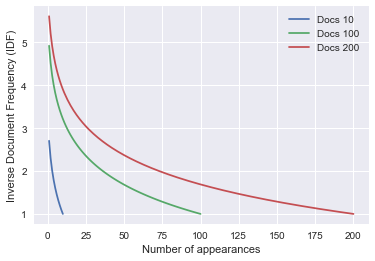

In [39]:
for docs in [10, 100, 200]:
    docs_range = range(1, docs + 1)
    plt.plot(docs_range, [idf(docs, d) for d in docs_range], label='Docs {}'.format(docs))
    
plt.xlabel('Number of appearances')
plt.ylabel('Inverse Document Frequency (IDF)')
plt.legend();

### Logistic Regression

In [40]:
x = tfidf.transform(corpus).toarray()
y = [1, 0, 0]

In [41]:
lr = LogisticRegression()
lr.fit(x, y)
lr.predict(x)

array([1, 0, 0])

In [42]:
lr.coef_[0].shape

(18,)

In [43]:
len(lr.coef_[0])

18

In [44]:
def plot_lr_coefficients(tfidf):
    a = tfidf.fit_transform(corpus)
    x = tfidf.transform(corpus).toarray()
    lr = LogisticRegression()
    lr.fit(x, y)
    df = pd.DataFrame({'Token': tfidf.get_feature_names(), 'Coefficient': lr.coef_[0]})
    df['Positive'] = df.Coefficient > 0
    colors = df.Positive.map({True: 'b', False: 'r'})
    df.set_index('Token').plot(kind='barh', color=[colors], legend=False, figsize=(8, 6))
    plt.xlabel('Coefficient')

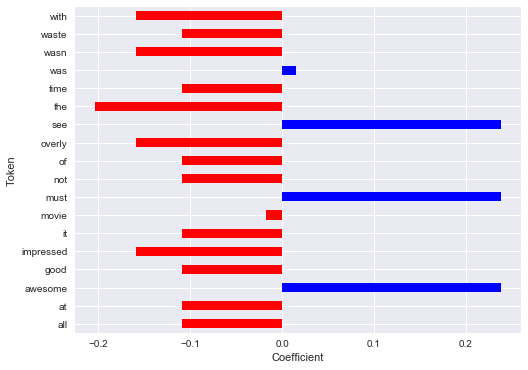

In [45]:
plot_lr_coefficients(TfidfVectorizer())

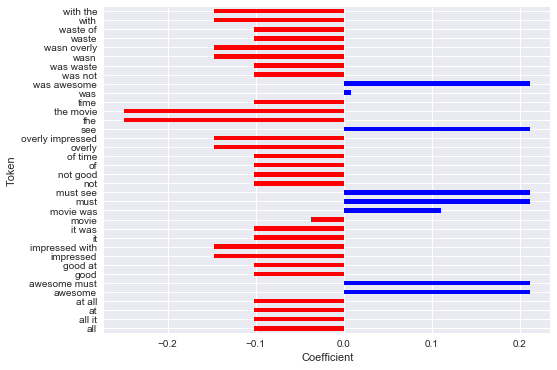

In [46]:
plot_lr_coefficients(CountVectorizer(ngram_range=(1, 2)))

### IMDB review sentiment data

In [442]:
# !wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xzf aclImdb_v1.tar.gz
# !rm aclImdb_v1.tar.gz

--2018-05-15 18:45:20--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu... 171.64.68.10
Connecting to ai.stanford.edu|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  16.5MB/s    in 5.3s    

2018-05-15 18:45:26 (15.2 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [38]:
def get_reviews(data_partition, class_label):
    path = 'aclImdb/{}/{}/*.txt'.format(data_partition, class_label)
    return [
        open(f).read()
        for f in glob.glob(path)
    ]

In [39]:
def get_dataset(data_partition):
    pos = get_reviews(data_partition, 'pos')
    neg = get_reviews(data_partition, 'neg')
    print('Found {} positive and {} negative examples'.format(len(pos), len(neg)))
    data = pos + neg
    labels = np.array([1 for _ in range(len(pos))] + [0 for _ in range(len(neg))])
    return data, labels

In [40]:
%%time
data_train, y_train = get_dataset('train')
data_test, y_test = get_dataset('test')

Found 12500 positive and 12500 negative examples
Found 12500 positive and 12500 negative examples
CPU times: user 3.23 s, sys: 2.96 s, total: 6.19 s
Wall time: 11.8 s


In [41]:
len(data_train)

25000

In [42]:
len(data_test)

25000

In [43]:
data_train[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

In [44]:
data_train[12500]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

In [45]:
%%time
vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), max_df=3/4, min_df=2)
x_train = vec.fit_transform(data_train)

CPU times: user 4.56 s, sys: 84.2 ms, total: 4.65 s
Wall time: 4.66 s


In [46]:
len(vec.vocabulary_)

44490

In [47]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
%%time
x_test = vec.transform(data_test)

CPU times: user 4.25 s, sys: 48.7 ms, total: 4.29 s
Wall time: 4.29 s


In [49]:
cross_val_score(LogisticRegression(), x_train, y_train, cv=5)

array([0.864 , 0.847 , 0.8512, 0.8504, 0.8638])

In [50]:
def traditional_ml(vec_class, model_object, stop_words, ngram_range, max_df, min_df, cv):
    vec = vec_class(stop_words=stop_words,
                    ngram_range=ngram_range,
                    max_df=max_df, min_df=min_df)
    x_train = vec.fit_transform(data_train)
    print('Vocabulary size: {}'.format(len(vec.vocabulary_)))
    x_test = vec.transform(data_test)
    scores = cross_val_score(model_object, x_train, y_train, cv=cv)
    scores_mean = scores.mean()
    scores_std = scores.std()
    print('Cross-validation scores mean: {:.2f}%, std: {:.2f}%'.format(scores_mean * 100,
                                                                       scores_std * 100))

In [51]:
%%time
traditional_ml(TfidfVectorizer, LogisticRegression(), 'english', (1, 1), 3 / 4, 2, cv=5)

Vocabulary size: 44490
Cross-validation scores mean: 85.53%, std: 0.72%
CPU times: user 10.7 s, sys: 162 ms, total: 10.9 s
Wall time: 10.9 s


In [61]:
%%time
traditional_ml(CountVectorizer, LogisticRegression(), 'english', (1, 1), 3 / 4, 2, cv=5)

Vocabulary size: 44490
Cross-validation scores mean: 82.97%, std: 1.15%
CPU times: user 20.3 s, sys: 338 ms, total: 20.7 s
Wall time: 20.7 s


In [62]:
%%time
traditional_ml(TfidfVectorizer, LogisticRegression(), None, (1, 1), 3 / 4, 2, cv=5)

Vocabulary size: 44789
Cross-validation scores mean: 86.27%, std: 0.56%
CPU times: user 14.2 s, sys: 409 ms, total: 14.6 s
Wall time: 14.6 s


In [63]:
%%time
traditional_ml(CountVectorizer, LogisticRegression(), None, (1, 1), 3 / 4, 2, cv=5)

Vocabulary size: 44789
Cross-validation scores mean: 83.88%, std: 1.19%
CPU times: user 32.7 s, sys: 569 ms, total: 33.2 s
Wall time: 33.5 s


In [64]:
%%time
traditional_ml(TfidfVectorizer, RandomForestClassifier(), None, (1, 1), 3 / 4, 2, cv=5)

Vocabulary size: 44789
Cross-validation scores mean: 74.56%, std: 0.68%
CPU times: user 38.1 s, sys: 654 ms, total: 38.7 s
Wall time: 38.9 s


### Deep learning

#### MLP

In [242]:
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # TODO: make sure this runs
# model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               11389696  
_________________________________________________________________
activation_20 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_21 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
__________

In [244]:
history = model.fit(x_train.toarray(), y_train
          epochs=5, batch_size=128,
          validation_split=1/3);

Train on 16666 samples, validate on 8334 samples
Epoch 1/5
16666/16666 [==============================] - 52s - loss: 0.3918 - acc: 0.8191 - val_loss: 0.7842 - val_acc: 0.6872
Epoch 2/5
16666/16666 [==============================] - 46s - loss: 0.1202 - acc: 0.9570 - val_loss: 0.7000 - val_acc: 0.7561
Epoch 3/5
16666/16666 [==============================] - 43s - loss: 0.0362 - acc: 0.9894 - val_loss: 1.0948 - val_acc: 0.7228
Epoch 4/5
16666/16666 [==============================] - 43s - loss: 0.0091 - acc: 0.9983 - val_loss: 1.4176 - val_acc: 0.7091
Epoch 5/5
16666/16666 [==============================] - 43s - loss: 0.0031 - acc: 0.9995 - val_loss: 1.8949 - val_acc: 0.6573


In [110]:
# model.evaluate(x_test.toarray(), to_categorical(y_test))

In [253]:
model.get_weights()[0].shape

(44490, 256)

In [254]:
vec.get_feature_names().index('awesome')

2981

In [259]:
vec.get_feature_names().index('great')

17112

In [255]:
vec.get_feature_names().index('terrible')

39522

In [264]:
vec.get_feature_names().index('awful')

2985

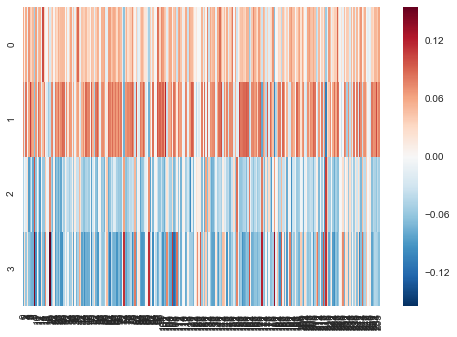

In [265]:
sns.heatmap(model.get_weights()[0][[2981, 17112, 39522, 2985]]) 

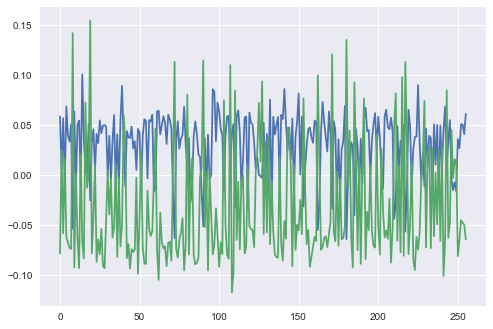

In [266]:
pd.Series(model.get_weights()[0][2981]).plot()
pd.Series(model.get_weights()[0][2985]).plot()

In [269]:
%%time
labels = ['Positive' if y == 1 else 'Negative' for y in y_train]
scattertext_df = pd.DataFrame({'text': data_train, 'label': labels})
corpus = scattertext.CorpusFromPandas(scattertext_df,
                                      category_col='label', text_col='text',
                                      nlp=scattertext.whitespace_nlp_with_sentences).build()

CPU times: user 1min 24s, sys: 1.25 s, total: 1min 26s
Wall time: 1min 26s


In [270]:
type(corpus)

scattertext.Corpus.Corpus

In [271]:
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['doesn', 'didn', 'isn', 've', 'wasn', 'film', 'don', 'plot', 'acting', 'scenes']


In [274]:
%%time
html = scattertext.produce_scattertext_explorer(corpus,
                                                category='Positive',
                                                category_name='Positive',
                                                max_terms=5000,
                                                not_category_name='Negative',
                                                width_in_pixels=1000
                                               )
open("imdb-vis.html", 'wb').write(html.encode('utf-8'))

CPU times: user 5min 2s, sys: 2.66 s, total: 5min 4s
Wall time: 5min 5s


In [276]:
%%time
term_freq_df = corpus.get_term_freq_df()
tf = term_freq_df.copy()

CPU times: user 2min 28s, sys: 29.4 s, total: 2min 57s
Wall time: 2min 57s


In [277]:
tf = tf[(tf['Positive freq'] > 0) & (tf['Negative freq'] > 0)]
tf['ratio'] = tf['Positive freq'] / tf['Negative freq']
tf.sort_values(by='ratio', ascending=True)

,Negative freq,Positive freq,ratio
term,,,
boll,141,1,0.007092
worst films,103,1,0.009709
uwe,99,1,0.010101
uwe boll,85,1,0.011765
just bad,81,1,0.012346
this crap,144,2,0.013889
avoid at,62,1,0.016129
thunderbirds,61,1,0.016393
beowulf,60,1,0.016667


In [54]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(256, input_dim=x_train.shape[1]))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam',
                  metrics=['accuracy'])
    
    return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=128, verbose=1)

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
results = cross_val_score(model, x_train.toarray(), y_train, cv=3)
print(results)

Epoch 1/5
16666/16666 [==============================] - 35s - loss: 0.3592 - acc: 0.8331    
Epoch 2/5
16666/16666 [==============================] - 28s - loss: 0.0939 - acc: 0.9682    
Epoch 3/5
16666/16666 [==============================] - 28s - loss: 0.0246 - acc: 0.9930    
Epoch 4/5
16666/16666 [==============================] - 28s - loss: 0.0066 - acc: 0.9987    
Epoch 5/5
16667/16667 [==============================] - 36s - loss: 0.3735 - acc: 0.8533    
Epoch 2/5
16667/16667 [==============================] - 28s - loss: 0.0987 - acc: 0.9666    
Epoch 3/5
16667/16667 [==============================] - 28s - loss: 0.0250 - acc: 0.9932    
Epoch 4/5
16667/16667 [==============================] - 28s - loss: 0.0051 - acc: 0.9992    
Epoch 5/5
16667/16667 [==============================] - 34s - loss: 0.3965 - acc: 0.8158    
Epoch 2/5
16667/16667 [==============================] - 28s - loss: 0.1226 - acc: 0.9570    
Epoch 3/5
16667/16667 [==============================] - 28s

In [56]:
x_train.shape

(25000, 44490)

In [55]:
create_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               11389696  
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_12 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total para

### embeddings

In [57]:
%%time
max_features = 40000
vec = CountVectorizer(binary=True, max_features=max_features)
vec.fit(data_train)

CPU times: user 4.75 s, sys: 157 ms, total: 4.91 s
Wall time: 4.92 s


In [58]:
len(vec.vocabulary_)

40000

In [59]:
tokenizer = vec.build_analyzer()
tokenizer(data_train[0])[:10]

['bromwell',
 'high',
 'is',
 'cartoon',
 'comedy',
 'it',
 'ran',
 'at',
 'the',
 'same']

In [60]:
def sequence_builder(vec, corpus):
    # Return a callable that handles preprocessing and tokenization
    # For more info see
    # https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/feature_extraction/text.py#L247
    analyzer = vec.build_analyzer()
    return np.array([
        [vec.vocabulary_[token]
         for token in tokenizer(doc)
         if token in vec.vocabulary_
        ]
        for doc in data_train
    ])

In [61]:
%%time
# alternatively can do this
# or preprocessing text
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
x_train_sequence = sequence_builder(vec, data_train)
x_test_sequence = sequence_builder(vec, data_test)

CPU times: user 7.85 s, sys: 107 ms, total: 7.95 s
Wall time: 8.02 s


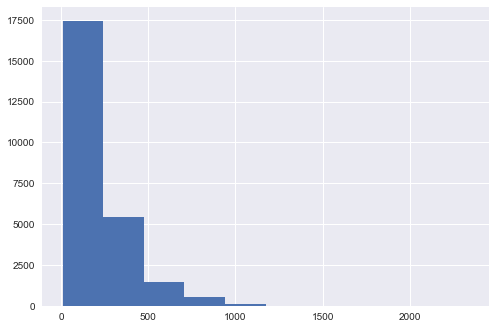

In [62]:
seq_lens = pd.Series([len(x) for x in x_train_sequence])
seq_lens.hist()

In [63]:
seq_lens.describe()

count    25000.000000
mean       225.362560
std        168.574272
min          9.000000
25%        121.000000
50%        167.000000
75%        274.000000
max       2336.000000
dtype: float64

In [64]:
seq_lens.max()

2336

In [65]:
%%time
x_train_sequence_padded = pad_sequences(x_train_sequence)
x_test_sequence_padded = pad_sequences(x_test_sequence)

CPU times: user 1.98 s, sys: 506 ms, total: 2.49 s
Wall time: 2.47 s


In [66]:
len(x_train_sequence_padded[0])

2336

In [67]:
%%time
maxlen = 250
x_train_sequence_padded = pad_sequences(x_train_sequence, maxlen=maxlen)
x_test_sequence_padded = pad_sequences(x_test_sequence, maxlen)

CPU times: user 1.2 s, sys: 79.6 ms, total: 1.28 s
Wall time: 1.28 s


In [68]:
x_train_sequence_padded.shape

(25000, 250)

In [69]:
x_train_sequence_padded[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,  4820, 16797, 18857,  5627,  7069,
       18914, 28494,

#### learned

In [70]:
x_train_sequence_padded.shape

(25000, 250)

In [73]:
embedding_dim = 300

def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

print(create_model().summary())

# Create model
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=128, verbose=1)

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
results = cross_val_score(model, x_train_sequence_padded, y_train, cv=3)
print('Results: {}'.format(results))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 300)          12000000  
_________________________________________________________________
flatten_5 (Flatten)          (None, 75000)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 250)               18750250  
_________________________________________________________________
dropout_21 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32128     
_________________________________________________________________
activation_17 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
__________

30M params is a bit too much, we have 40k vocab and 25k examples which is 1B things but still.

In [75]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

print(create_model().summary())

# Create model
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=128, verbose=1)

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
results = cross_val_score(model, x_train_sequence_padded, y_train, cv=3)
print('Results: {}'.format(results))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
flatten_11 (Flatten)         (None, 75000)             0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 75000)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 75001     
Total params: 12,075,001.0
Trainable params: 12,075,001.0
Non-trainable params: 0.0
_________________________________________________________________
None
Epoch 1/5
16666/16666 [==============================] - 28s - loss: 0.4751 - acc: 0.7790    
Epoch 2/5
16666/16666 [==============================] - 27s - loss: 0.1609 - acc: 0.9506    
Epoch 3/5
16666/16666 [==============================] - 26s - 

#### explore

In [ ]:
model = create_model()
model.fit(x_train_sequence_padded,
          y_train,
          epochs=5)

In [150]:
model.get_weights()[0].shape

(40000, 300)

In [151]:
def word_distance(word1, word2,
                  weights=model.get_weights()[0],
                  distance_function=np.linalg.norm):
    word1_index = vec.vocabulary_[word1]
    word2_index = vec.vocabulary_[word2]
    word1_vec = weights[word1_index]
    word2_vec = weights[word2_index]
    diff = word1_vec - word2_vec
    return distance_function(diff)

In [152]:
vec.vocabulary_['movie']

23445

In [153]:
vec.vocabulary_['film']

13225

In [154]:
model.get_weights()[0][23445].shape

(300,)

In [155]:
word_distance('movie', 'film')

1.3873523

In [156]:
word_distance('awesome', 'awful')

5.2641897

In [157]:
word_distance('worst', 'best')

6.158282

In [158]:
word_distance('awesome', 'terrible')

4.736925

In [159]:
word_distance('waste', 'poor')

2.094317

In [160]:
word_distance('waste', 'poor')

2.094317

In [161]:
word_distance('great', 'awesome')

1.5102595

In [162]:
word_distance('love', 'hate')

2.010684

In [163]:
word_distance('drama', 'comedy')

1.5568086

In [164]:
weights = model.get_weights()[0]

In [171]:
def most_similar(word, n=5):
    q = weights[vec.vocabulary_[word]]
    return sorted([(np.linalg.norm(q - weights[vec.vocabulary_[word]]), word) for word in vec.vocabulary_],
       key=lambda x: x[0])[:n]

In [179]:
most_similar('waste')

[(0.0, 'waste'),
 (1.6937237, 'poorly'),
 (1.7261549, 'worst'),
 (1.7480385, 'horrible'),
 (1.762903, 'awful')]

In [180]:
most_similar('excellent')

[(0.0, 'excellent'),
 (1.4783454, 'superb'),
 (1.5926542, 'wonderful'),
 (1.6464489, 'touching'),
 (1.6613092, 'amazing')]

#### pre-trained

In [206]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!rm glove.6B.zip
!rm glove.6B.50d.txt
!rm glove.6B.100d.txt
!rm glove.6B.200d.txt

--2018-05-20 12:39:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu... 171.64.67.140
Connecting to nlp.stanford.edu|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-05-20 12:39:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  9.29MB/s    in 78s     

2018-05-20 12:40:52 (10.5 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [210]:
!ls -lht glove*

-rw-rw-r--@ 1 amir.ziai  10000   990M Aug 27  2014 glove.6B.300d.txt


In [246]:
!head -1 glove.6B.300d.txt

the 0.04656 0.21318 -0.0074364 -0.45854 -0.035639 0.23643 -0.28836 0.21521 -0.13486 -1.6413 -0.26091 0.032434 0.056621 -0.043296 -0.021672 0.22476 -0.075129 -0.067018 -0.14247 0.038825 -0.18951 0.29977 0.39305 0.17887 -0.17343 -0.21178 0.23617 -0.063681 -0.42318 -0.11661 0.093754 0.17296 -0.33073 0.49112 -0.68995 -0.092462 0.24742 -0.17991 0.097908 0.083118 0.15299 -0.27276 -0.038934 0.54453 0.53737 0.29105 -0.0073514 0.04788 -0.4076 -0.026759 0.17919 0.010977 -0.10963 -0.26395 0.07399 0.26236 -0.1508 0.34623 0.25758 0.11971 -0.037135 -0.071593 0.43898 -0.040764 0.016425 -0.4464 0.17197 0.046246 0.058639 0.041499 0.53948 0.52495 0.11361 -0.048315 -0.36385 0.18704 0.092761 -0.11129 -0.42085 0.13992 -0.39338 -0.067945 0.12188 0.16707 0.075169 -0.015529 -0.19499 0.19638 0.053194 0.2517 -0.34845 -0.10638 -0.34692 -0.19024 -0.2004 0.12154 -0.29208 0.023353 -0.11618 -0.35768 0.062304 0.35884 0.02906 0.0073005 0.0049482 -0.15048 -0.12313 0.19337 0.12173 0.44503 0.25147 0.10781 -0.17716 0.0386

In [222]:
len(embedding)

400000

In [223]:
embedding_matrix = np.zeros((max_features, embedding_dim))

In [227]:
next(iter(vec.vocabulary_))

'andromeda'

In [228]:
vec.vocabulary_['andromeda']

1624

In [234]:
def load_embedding(path, embedding_dim):
    embedding = {}
    for line in open(path):
        word, *values = line.split()
        embedding[word] = np.asarray(values)
    
    embedding_matrix = np.zeros((max_features, embedding_dim))
    for word, word_index in vec.vocabulary_.items():
        if word in embedding:
            embedding_matrix[word_index] = embedding[word]
        
    return embedding_matrix

In [235]:
%%time
embedding_glove300d = load_embedding('glove.6B.300d.txt', 300)

CPU times: user 32.7 s, sys: 4.81 s, total: 37.6 s
Wall time: 37.9 s


In [236]:
embedding_glove300d.shape

(40000, 300)

In [248]:
def most_similar(weights, word, n=5):
    q = weights[vec.vocabulary_[word]]
    return sorted([(np.linalg.norm(q - weights[vec.vocabulary_[word]]), word) for word in vec.vocabulary_],
       key=lambda x: x[0])[:n]

In [249]:
most_similar(embedding_glove300d, 'love')

[(0.0, 'love'),
 (5.092279474471483, 'loves'),
 (5.196532417405527, 'passion'),
 (5.312959134001991, 'always'),
 (5.342987625833064, 'loved')]

In [250]:
most_similar(embedding_glove300d, 'awful')

[(0.0, 'awful'),
 (3.435496499258442, 'horrible'),
 (3.744205737861488, 'terrible'),
 (4.063197551904514, 'dreadful'),
 (4.694474766884046, 'horrendous')]

In [251]:
most_similar(embedding_glove300d, 'movie')

[(0.0, 'movie'),
 (3.632431241088511, 'movies'),
 (3.6684420774405804, 'film'),
 (4.39624693123189, 'films'),
 (5.262785903275571, 'sequel')]

In [256]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.layers[0].set_weights([embedding_glove300d])
    model.layers[0].trainable = False
    return model

print(create_model().summary())

# Create model
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=128, verbose=1)

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
results = cross_val_score(model, x_train_sequence_padded, y_train, cv=3)
print('Results: {}'.format(results))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
flatten_17 (Flatten)         (None, 75000)             0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 75000)             0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 75001     
Total params: 12,075,001.0
Trainable params: 75,001.0
Non-trainable params: 12,000,000.0
_________________________________________________________________
None
Epoch 1/5
16666/16666 [==============================] - 27s - loss: 0.6020 - acc: 0.7433    
Epoch 2/5
16666/16666 [==============================] - 27s - loss: 0.2432 - acc: 0.9011    
Epoch 3/5
16666/16666 [==============================] - 2

### Sequence

In [300]:
def cv_report(create_model, epochs=5, batch_size=128, verbose=1, cv=3):
    print(create_model().summary())
    print()

    # Create model
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=batch_size, verbose=verbose)

    # kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    results = cross_val_score(model, x_train_sequence_padded, y_train, cv=cv)
    print()
    print('Results: {}, mean: {:.2f}%, std: {:.2f}%'.format(results,
                                                            100 * results.mean(), 100 * results.std()))

In [286]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(32))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.layers[0].set_weights([embedding_glove300d])
    model.layers[0].trainable = False
    return model

cv_report(create_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
dropout_68 (Dropout)         (None, 250, 300)          0         
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 32)                10656     
_________________________________________________________________
dropout_69 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 33        
Total params: 12,010,689.0
Trainable params: 10,689.0
Non-trainable params: 12,000,000.0
_________________________________________________________________
None

Epoch 1/5
16666/16666 [==============================] - 39s - loss: 0.6312 - acc: 0.6982    
Epoch 2/5
16666/166

In [287]:
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cv_report(create_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_45 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
dropout_76 (Dropout)         (None, 250, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dropout_77 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 65        
Total params: 12,093,505.0
Trainable params: 12,093,505.0
Non-trainable params: 0.0
_________________________________________________________________
None

Epoch 1/5
16666/16666 [==============================] - 118s - loss: 0.4447 - acc: 0.8000   
Epoch 2/5
16666/16666 [=

In [295]:
# stacked LSTMs
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cv_report(create_model, epochs=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_55 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
dropout_102 (Dropout)        (None, 250, 300)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 250, 64)           93440     
_________________________________________________________________
dropout_103 (Dropout)        (None, 250, 64)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 250, 64)           33024     
_________________________________________________________________
dropout_104 (Dropout)        (None, 250, 64)           0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 250, 64)           33024     
__________

In [301]:
# stacked bi-LSTMs
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cv_report(create_model, epochs=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_63 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
dropout_142 (Dropout)        (None, 250, 300)          0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 250, 128)          186880    
_________________________________________________________________
dropout_143 (Dropout)        (None, 250, 128)          0         
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 250, 128)          98816     
_________________________________________________________________
dropout_144 (Dropout)        (None, 250, 128)          0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 250, 128)          98816     
__________

#### ConvNet

In [306]:
# stacked LSTMs
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Dropout(0.5))
    # Add 1D conv + max pooling
    model.add(Conv1D(32, 7, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(32, 7, activation='relu'))
    model.add(GlobalMaxPooling1D())
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cv_report(create_model, epochs=3)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_69 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
dropout_164 (Dropout)        (None, 250, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 244, 32)           67232     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 42, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dro

#### ConvNet + RNN

In [308]:
# stacked LSTMs
def create_model():
    model = Sequential()
    model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
    model.add(Dropout(0.5))
    # Add 1D conv + max pooling
    model.add(Conv1D(32, 7, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(32, 7, activation='relu'))
    model.add(GRU(64, recurrent_dropout=0.5))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cv_report(create_model, epochs=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_73 (Embedding)     (None, 250, 300)          12000000  
_________________________________________________________________
dropout_172 (Dropout)        (None, 250, 300)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 244, 32)           67232     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 42, 32)            7200      
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dropout_173 (Dropout)        (None, 64)                0         
__________

## seq2seq

### Machine Translation

#### char-level

Visit http://www.manythings.org/anki/ for more information

In [309]:
!wget http://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip
!rm spa-eng.zip

--2018-05-21 16:54:55--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org... 104.24.109.196, 104.24.108.196, 2400:cb00:2048:1::6818:6dc4, ...
Connecting to www.manythings.org|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2786685 (2.7M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   2.66M  2.22MB/s    in 1.2s    

2018-05-21 16:54:57 (2.22 MB/s) - ‘spa-eng.zip’ saved [2786685/2786685]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [310]:
!ls -lht spa.txt

-rw-r--r--@ 1 amir.ziai  10000   7.7M May 13 15:50 spa.txt


In [330]:
!wc -l spa.txt

  118964 spa.txt


In [17]:
%%time
sources = []
targets = []
chars_source = set()
chars_target = set()
max_source = 0
max_target = 0
path = 'spa.txt'

for line in open(path):
     source, target = line.strip().split('\t')
        
     sources.append(source)
     targets.append(target)
     
     max_source = max(max_source, len(source))
     max_target = max(max_target, len(target))
     for c in source:
        chars_source.add(c)
     for c in target:
        chars_target.add(c)

CPU times: user 1.04 s, sys: 21.9 ms, total: 1.06 s
Wall time: 1.06 s


In [18]:
source_dict = dict(zip(chars_source, range(len(chars_source))))
target_dict = dict(zip(chars_target, range(len(chars_target))))
print('Source characteres: {}'.format(len(source_dict)))
print('Target characteres: {}'.format(len(target_dict)))

Source characteres: 90
Target characteres: 111


In [19]:
%%time
encoder_in = np.zeros((len(sources), max_source, len(chars_source)))
decoder_in = np.zeros((len(sources), max_target, len(chars_target)))
decoder_out = np.zeros((len(sources), max_target, len(chars_target)))

for i, (source, target) in enumerate(zip(sources, targets)):
    for t, c in enumerate(source):
        encoder_in[i, t, source_dict[c]] = 1
        
    for t, c in enumerate(target):
        decoder_in[i, t, target_dict[c]] = 1
        if t > 0:
            decoder_out[i, t - 1, target_dict[c]] = 1

CPU times: user 8.82 s, sys: 4.24 s, total: 13.1 s
Wall time: 13.3 s


In [43]:
num_encoder_tokens = len(chars_source)
num_decoder_tokens = len(chars_target)
encoder_input_data = encoder_in
decoder_input_data = decoder_in
decoder_target_data = decoder_out
batch_size = 64
epochs = 100

In [59]:
data_path = 'spa.txt'
num_samples = 10000

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 86
Max sequence length for inputs: 17
Max sequence length for outputs: 42


In [54]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 21s 3ms/step - loss: 1.1372 - val_loss: 1.2104
Epoch 2/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.9464 - val_loss: 1.0098
Epoch 3/100
8000/8000 [==============================] - 24s 3ms/step - loss: 0.8217 - val_loss: 0.9363
Epoch 4/100
8000/8000 [==============================] - 21s 3ms/step - loss: 0.7602 - val_loss: 0.8850
Epoch 5/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.7104 - val_loss: 0.8296
Epoch 6/100
8000/8000 [==============================] - 22s 3ms/step - loss: 0.6713 - val_loss: 0.7948
Epoch 7/100
8000/8000 [==============================] - 23s 3ms/step - loss: 0.6385 - val_loss: 0.7816
Epoch 8/100
8000/8000 [==============================] - 22s 3ms/step - loss: 0.6101 - val_loss: 0.7431
Epoch 9/100
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5842 - val_loss: 0.7287
Epoch 10/100
800

/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:2379: UserWarning: Layer lstm_23 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_22/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_22/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


In [60]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Vete.

-
Input sentence: Go.
Decoded sentence: Vete.

-
Input sentence: Go.
Decoded sentence: Vete.

-
Input sentence: Go.
Decoded sentence: Vete.

-
Input sentence: Hi.
Decoded sentence: Hola.

-
Input sentence: Run!
Decoded sentence: ¡Corre!

-
Input sentence: Run.
Decoded sentence: Corred.

-
Input sentence: Who?
Decoded sentence: ¿Quién?

-
Input sentence: Fire!
Decoded sentence: ¡Incendio!

-
Input sentence: Fire!
Decoded sentence: ¡Incendio!

-
Input sentence: Fire!
Decoded sentence: ¡Incendio!

-
Input sentence: Help!
Decoded sentence: ¡Auxilio!

-
Input sentence: Help!
Decoded sentence: ¡Auxilio!

-
Input sentence: Help!
Decoded sentence: ¡Auxilio!

-
Input sentence: Jump!
Decoded sentence: ¡Salta!

-
Input sentence: Jump.
Decoded sentence: Salte.

-
Input sentence: Stop!
Decoded sentence: ¡Pare!

-
Input sentence: Stop!
Decoded sentence: ¡Pare!

-
Input sentence: Stop!
Decoded sentence: ¡Pare!

-
Input sentence: Wait!
Decoded sentence: ¡

In [65]:
encoder_input_data.shape

(10000, 17, 71)

In [68]:
encoder_input_data[-2:-1]

(1, 17, 71)

In [64]:
input_seq.shape

(1, 17, 71)

In [62]:
seq_index = 1202
# Take one sequence (part of the training set)
# for trying out decoding.
input_seq = encoder_input_data[seq_index: seq_index + 1]
decoded_sentence = decode_sequence(input_seq)
print('-')
print('Input sentence:', input_texts[seq_index])
print('Decoded sentence:', decoded_sentence)

-
Input sentence: Is this OK?
Decoded sentence: ¿Esto es bueno?



### Chatbots

In [69]:
# !wget https://raw.githubusercontent.com/oswaldoludwig/Seq2seq-Chatbot-for-Keras/master/vocabulary_movie
# !wget https://raw.githubusercontent.com/oswaldoludwig/Seq2seq-Chatbot-for-Keras/master/conversation.py

--2018-05-22 16:18:10--  https://raw.githubusercontent.com/oswaldoludwig/Seq2seq-Chatbot-for-Keras/master/vocabulary_movie
Resolving raw.githubusercontent.com... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 213637 (209K) [text/plain]
Saving to: ‘vocabulary_movie’

vocabulary_movie    100%[===================>] 208.63K  --.-KB/s    in 0.07s   

2018-05-22 16:18:15 (2.78 MB/s) - ‘vocabulary_movie’ saved [213637/213637]



In [72]:
!wget https://raw.githubusercontent.com/chen0040/keras-chatbot-web-api/master/chatbot_train/data/cornell-dialogs/movie_lines_cleaned_10k.txt

--2018-05-22 18:11:49--  https://raw.githubusercontent.com/chen0040/keras-chatbot-web-api/master/chatbot_train/data/cornell-dialogs/movie_lines_cleaned_10k.txt
Resolving raw.githubusercontent.com... 151.101.64.133, 151.101.128.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 542439 (530K) [text/plain]
Saving to: ‘movie_lines_cleaned_10k.txt’

movie_lines_cleaned 100%[===================>] 529.73K   639KB/s    in 0.8s    

2018-05-22 18:11:51 (639 KB/s) - ‘movie_lines_cleaned_10k.txt’ saved [542439/542439]



In [80]:
BATCH_SIZE = 64
NUM_EPOCHS = 100
HIDDEN_UNITS = 256
MAX_INPUT_SEQ_LENGTH = 40
MAX_TARGET_SEQ_LENGTH = 40
MAX_VOCAB_SIZE = 800
DATA_PATH = 'movie_lines_cleaned_10k.txt'
WEIGHT_FILE_PATH = 'word-weights.h5'

input_counter = Counter()
target_counter = Counter()

lines = open(DATA_PATH, 'rt', encoding='utf8').read().split('\n')
input_texts = []
target_texts = []

prev_words = []
for line in lines:

    next_words = [w.lower() for w in nltk.word_tokenize(line)]
    if len(next_words) > MAX_TARGET_SEQ_LENGTH:
        next_words = next_words[0:MAX_TARGET_SEQ_LENGTH]

    if len(prev_words) > 0:
        input_texts.append(prev_words)
        for w in prev_words:
            input_counter[w] += 1

        target_words = next_words[:]
        target_words.insert(0, 'START')
        target_words.append('END')
        for w in target_words:
            target_counter[w] += 1
        target_texts.append(target_words)

    prev_words = next_words

input_word2idx = dict()
target_word2idx = dict()
for idx, word in enumerate(input_counter.most_common(MAX_VOCAB_SIZE)):
    input_word2idx[word[0]] = idx + 2
for idx, word in enumerate(target_counter.most_common(MAX_VOCAB_SIZE)):
    target_word2idx[word[0]] = idx + 1

input_word2idx['PAD'] = 0
input_word2idx['UNK'] = 1
target_word2idx['UNK'] = 0

input_idx2word = dict([(idx, word) for word, idx in input_word2idx.items()])
target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

num_encoder_tokens = len(input_idx2word)
num_decoder_tokens = len(target_idx2word)

np.save('word-input-word2idx.npy', input_word2idx)
np.save('word-input-idx2word.npy', input_idx2word)
np.save('word-target-word2idx.npy', target_word2idx)
np.save('word-target-idx2word.npy', target_idx2word)

encoder_input_data = []

encoder_max_seq_length = 0
decoder_max_seq_length = 0

for input_words, target_words in zip(input_texts, target_texts):
    encoder_input_wids = []
    for w in input_words:
        w2idx = 1  # default [UNK]
        if w in input_word2idx:
            w2idx = input_word2idx[w]
        encoder_input_wids.append(w2idx)

    encoder_input_data.append(encoder_input_wids)
    encoder_max_seq_length = max(len(encoder_input_wids), encoder_max_seq_length)
    decoder_max_seq_length = max(len(target_words), decoder_max_seq_length)

context = dict()
context['num_encoder_tokens'] = num_encoder_tokens
context['num_decoder_tokens'] = num_decoder_tokens
context['encoder_max_seq_length'] = encoder_max_seq_length
context['decoder_max_seq_length'] = decoder_max_seq_length

print(context)
# np.save('word-context.npy', context)


def generate_batch(input_data, output_text_data):
    num_batches = len(input_data) // BATCH_SIZE
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * BATCH_SIZE
            end = (batchIdx + 1) * BATCH_SIZE
            encoder_input_data_batch = pad_sequences(input_data[start:end], encoder_max_seq_length)
            decoder_target_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens))
            decoder_input_data_batch = np.zeros(shape=(BATCH_SIZE, decoder_max_seq_length, num_decoder_tokens))
            for lineIdx, target_words in enumerate(output_text_data[start:end]):
                for idx, w in enumerate(target_words):
                    w2idx = 0  # default [UNK]
                    if w in target_word2idx:
                        w2idx = target_word2idx[w]
                    decoder_input_data_batch[lineIdx, idx, w2idx] = 1
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, w2idx] = 1
            yield [encoder_input_data_batch, decoder_input_data_batch], decoder_target_data_batch


encoder_inputs = Input(shape=(None,), name='encoder_inputs')
encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=HIDDEN_UNITS,
                              input_length=encoder_max_seq_length, name='encoder_embedding')
encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name='encoder_lstm')
encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embedding(encoder_inputs))
encoder_states = [encoder_state_h, encoder_state_c]

decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')
decoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, return_sequences=True, name='decoder_lstm')
decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                 initial_state=encoder_states)
decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

json = model.to_json()
open('word-architecture.json', 'w').write(json)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(encoder_input_data, target_texts, test_size=0.2, random_state=42)

print(len(Xtrain))
print(len(Xtest))

train_gen = generate_batch(Xtrain, Ytrain)
test_gen = generate_batch(Xtest, Ytest)

train_num_batches = len(Xtrain) // BATCH_SIZE
test_num_batches = len(Xtest) // BATCH_SIZE

checkpoint = ModelCheckpoint(filepath=WEIGHT_FILE_PATH, save_best_only=True)
model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                    epochs=NUM_EPOCHS,
                    verbose=1, validation_data=test_gen, validation_steps=test_num_batches, callbacks=[checkpoint])

model.save_weights(WEIGHT_FILE_PATH)

{'num_encoder_tokens': 802, 'num_decoder_tokens': 801, 'encoder_max_seq_length': 40, 'decoder_max_seq_length': 42}


/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:2379: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_lstm_2/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'encoder_lstm_2/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


7997
2000
Epoch 1/100
124/124 [==============================] - 92s 742ms/step - loss: 1.5122 - val_loss: 1.4305
Epoch 2/100
124/124 [==============================] - 83s 667ms/step - loss: 1.4234 - val_loss: 1.3461
Epoch 3/100
124/124 [==============================] - 86s 696ms/step - loss: 1.3404 - val_loss: 1.2763
Epoch 4/100
124/124 [==============================] - 83s 667ms/step - loss: 1.2765 - val_loss: 1.2317
Epoch 5/100
124/124 [==============================] - 88s 711ms/step - loss: 1.2319 - val_loss: 1.1981
Epoch 6/100
124/124 [==============================] - 84s 679ms/step - loss: 1.1991 - val_loss: 1.1759
Epoch 7/100
124/124 [==============================] - 86s 693ms/step - loss: 1.1806 - val_loss: 1.1622
Epoch 8/100
124/124 [==============================] - 86s 695ms/step - loss: 1.1562 - val_loss: 1.1483
Epoch 9/100
124/124 [==============================] - 83s 672ms/step - loss: 1.1368 - val_loss: 1.1374
Epoch 10/100
124/124 [==============================] 

124/124 [==============================] - 76s 615ms/step - loss: 0.3080 - val_loss: 1.7739
Epoch 80/100
124/124 [==============================] - 75s 605ms/step - loss: 0.3023 - val_loss: 1.7794
Epoch 81/100
124/124 [==============================] - 76s 616ms/step - loss: 0.2961 - val_loss: 1.7926
Epoch 82/100
124/124 [==============================] - 78s 633ms/step - loss: 0.2893 - val_loss: 1.8038
Epoch 83/100
124/124 [==============================] - 79s 634ms/step - loss: 0.2833 - val_loss: 1.8207
Epoch 84/100
124/124 [==============================] - 77s 618ms/step - loss: 0.2749 - val_loss: 1.8287
Epoch 85/100
124/124 [==============================] - 76s 612ms/step - loss: 0.2710 - val_loss: 1.8383
Epoch 86/100
124/124 [==============================] - 78s 626ms/step - loss: 0.2637 - val_loss: 1.8501
Epoch 87/100
124/124 [==============================] - 76s 615ms/step - loss: 0.2578 - val_loss: 1.8609
Epoch 88/100
124/124 [==============================] - 74s 597ms/st

In [81]:
WEIGHT_FILE_PATH

'word-weights.h5'

### inference

In [88]:
HIDDEN_UNITS = 256


class CornellWordChatBot(object):
    model = None
    encoder_model = None
    decoder_model = None
    input_word2idx = None
    input_idx2word = None
    target_word2idx = None
    target_idx2word = None
    max_encoder_seq_length = None
    max_decoder_seq_length = None
    num_encoder_tokens = None
    num_decoder_tokens = None

    def __init__(self):
        self.input_word2idx = np.load('word-input-word2idx.npy').item()
        self.input_idx2word = np.load('word-input-idx2word.npy').item()
        self.target_word2idx = np.load('word-target-word2idx.npy').item()
        self.target_idx2word = np.load('word-target-idx2word.npy').item()
        context = np.load('word-context.npy').item()
        self.max_encoder_seq_length = context['encoder_max_seq_length']
        self.max_decoder_seq_length = context['decoder_max_seq_length']
        self.num_encoder_tokens = context['num_encoder_tokens']
        self.num_decoder_tokens = context['num_decoder_tokens']

        encoder_inputs = Input(shape=(None, ), name='encoder_inputs')
        encoder_embedding = Embedding(input_dim=self.num_encoder_tokens, output_dim=HIDDEN_UNITS,
                                      input_length=self.max_encoder_seq_length, name='encoder_embedding')
        encoder_lstm = LSTM(units=HIDDEN_UNITS, return_state=True, name="encoder_lstm")
        encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_embedding(encoder_inputs))
        encoder_states = [encoder_state_h, encoder_state_c]

        decoder_inputs = Input(shape=(None, self.num_decoder_tokens), name='decoder_inputs')
        decoder_lstm = LSTM(units=HIDDEN_UNITS, return_sequences=True, return_state=True, name='decoder_lstm')
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax', name='decoder_dense')
        decoder_outputs = decoder_dense(decoder_outputs)

        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        # model_json = open('../chatbot_train/models/cornell/word-architecture.json', 'r').read()
        # self.model = model_from_json(model_json)
        self.model.load_weights('word-weights.h5')
        self.model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

        self.encoder_model = Model(encoder_inputs, encoder_states)

        decoder_state_inputs = [Input(shape=(HIDDEN_UNITS,)), Input(shape=(HIDDEN_UNITS,))]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

    def reply(self, input_text):
        input_seq = []
        input_wids = []
        for word in nltk.word_tokenize(input_text.lower()):
            idx = 1  # default [UNK]
            if word in self.input_word2idx:
                idx = self.input_word2idx[word]
            input_wids.append(idx)
        input_seq.append(input_wids)
        input_seq = pad_sequences(input_seq, self.max_encoder_seq_length)
        states_value = self.encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.num_decoder_tokens))
        target_seq[0, 0, self.target_word2idx['START']] = 1
        target_text = ''
        target_text_len = 0
        terminated = False
        while not terminated:
            output_tokens, h, c = self.decoder_model.predict([target_seq] + states_value)

            sample_token_idx = np.argmax(output_tokens[0, -1, :])
            sample_word = self.target_idx2word[sample_token_idx]
            target_text_len += 1

            if sample_word != 'START' and sample_word != 'END':
                target_text += ' ' + sample_word

            if sample_word == 'END' or target_text_len >= self.max_decoder_seq_length:
                terminated = True

            target_seq = np.zeros((1, 1, self.num_decoder_tokens))
            target_seq[0, 0, sample_token_idx] = 1

            states_value = [h, c]
        return target_text.strip()

    def test_run(self):
        print(self.reply('do you listen to this crap?'))
        print(self.reply('Did you change your hair?'))
        print(self.reply('Get out!'))

In [89]:
!ls -lht *.npy

-rw-r--r--@ 1 amir.ziai  10000   442B May 23 00:26 word-context.npy
-rw-r--r--@ 1 amir.ziai  10000    13K May 23 00:26 word-input-idx2word.npy
-rw-r--r--@ 1 amir.ziai  10000    13K May 23 00:26 word-input-word2idx.npy
-rw-r--r--@ 1 amir.ziai  10000    13K May 23 00:26 word-target-idx2word.npy
-rw-r--r--@ 1 amir.ziai  10000    13K May 23 00:26 word-target-word2idx.npy


In [91]:
bot = CornellWordChatBot()

In [92]:
bot.test_run()

no ... i can UNK you for me .
you 'd have to get her out ?
UNK !


In [95]:
bot.reply('hello')

"UNK a UNK . i saw it . i was UNK in UNK and i 'm coming in ."

In [97]:
bot.reply('my name is amir')

"you 're UNK against one , jesse . you UNK me ."

In [99]:
bot.reply('Haha')

"i 'm UNK , i got ta do . i 'm sorry ."